# Custom image detection with fast.ai

## Overview

We want to make a model that will work for our specific, unique problem: detecting whether helicopter flight maps show a copter was "circling" or "not circling."

### Transfer learning with a pre-trained model

One way to solve this problem would be to teach, or _train_ a _model_ – really a complex mathematical formula – to match images to labels. For good results, we'd need to use millions of images. It's doable ... but there's another option.

We'll use a _pre-trained model_ – one already trained by some other, kind people, who built it using millions of images and then shared it on the internet for others to use. We'll use the "smarts" of that model, which has learned to detect patterns in images generally, to solve our particular problem. We do that by _additionally_ training the original model on our own data set – the helicopter flight maps.

### ResNet

[ResNet](https://arxiv.org/abs/1512.03385) is a pre-trained model that was trained on the images and labels of 1.2 million pictures in a database called [ImageNet](http://www.image-net.org/about-overview).

It is a _neural network_ that has "learned" how to "look" at those images and make a guess of what the image contains from a list of 1,000 possible labels.

But we want just two labels: "circling" and "not circling"

So we strip off the last calculations of the ResNet model ... the part that guesses between 1,000 possibilites ... and train it with our images to guess just two possibilities.

### fast.ai

[Fast.ai](https://fast.ai) is the software we'll use to take the complex mathematical formula described by the ResNet model, do transfer-learning on the original model with our custom maps, and apply the final model to new images. 

## The Plan

We're going to train a model to recognize helicopter flight maps as either "circling" or "not circling" using a relatively small number of training images (just shy of 300 total).

- We'll start with a moodel pre-trained on 1.2 million image.
- Next we'll use "transfer learning" with fast.ai to further train that model with our helicopter maps

## Credits

This notebook started as a copy of the lesson 1 notebook in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. 

For more of my process here, see [this blog post](https://qz.ai/spotting-circling-helicopters/).

In [0]:
## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
## Loading libraries
import warnings
warnings.filterwarnings('ignore')
from fastai.vision import *
from fastai.metrics import error_rate
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.59
cuda: True


We're going to download some data for this notebook, which is mainly just a folder containing some pictures.

Probably the trickiest part of machine learning image problems involve pairing the images with their proper labels. There are many ways to do this. Sometimes the labels are in the file names. Sometimes they're in a list. Ours are in two separate folders, or directories:

- One folder contains circling images
- One folder contains not-circling images

These folders were made by sorting through about 300 maps of helicopter flight paths.

In [0]:
# Downloading the data
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/chopper_data.zip --quiet
!unzip -q chopper_data.zip
print('Done.')

Done.


In [0]:
%ls data/choppers

circling/  not_circling/


In [0]:
data_path ='./data/choppers'

In [0]:
my_transforms = None

data = (ImageList.from_folder(data_path) # Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()        # How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder()        # How to label? -> get from the folder name
        .transform(my_transforms, size=600)  # Data augmentation? -> use tfms with a size of 600, because they all are
        .databunch(bs=16))          # Size of simultaneous batches -> 16 (higher is faster & uses more memory)
print('Done.')

Done.


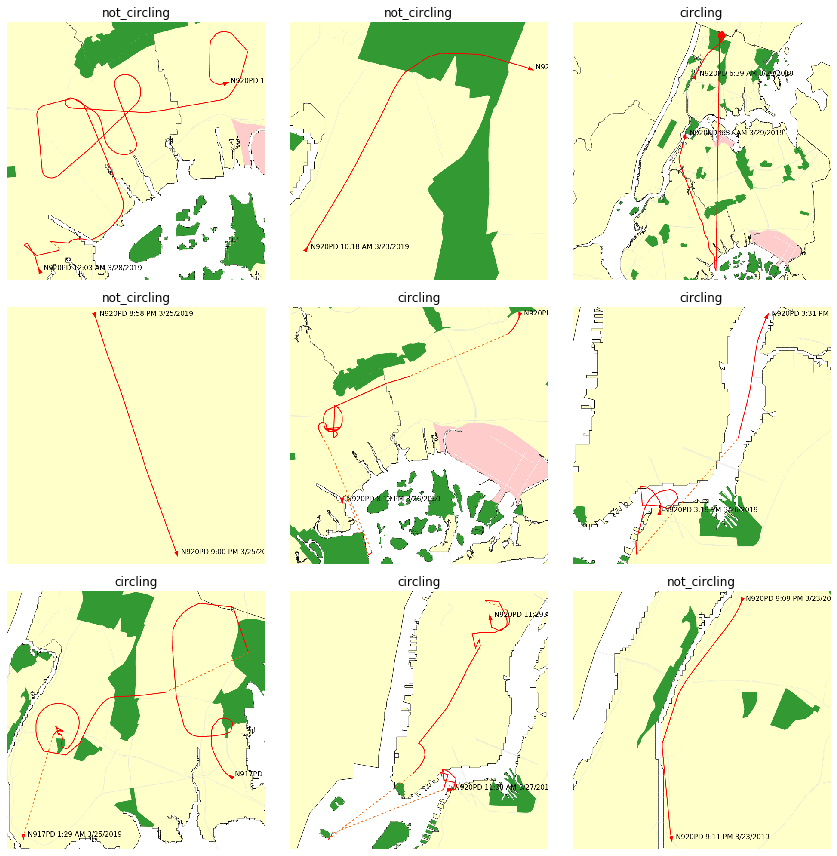

In [0]:
data.show_batch(rows=3)

In [0]:
print(data.classes)

['circling', 'not_circling']


## The Code

Now we will start training our model - which is a convolutional neural network. For a deep dive on that, definitely check out the fast.ai courses.

But for now, you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories: `circling` and `not_circling`

### Transfer learning with resnet34

Training a computer-vision mode from scratch to solve our problem would take thousands of images. Maybe more. Instead we take advantage of an existing model that was trained to detect objects -- from planes, to cars, to dogs, to birds -- by processing millions of images. This model is called "resnet34."

With fast.ai we can infuse this model with our images (and their labels). This takes advantage of all of resnet34's "knowledge" of image-detection and tacks on our particular problem. This technique is called "transfer learning." 

First we load our `data` and `model.resnet34` together into a training model known as a "learner."

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]


We will train for 10 epochs (10 cycles through all our data).

In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.012186,0.723731,0.277778,00:15
1,0.844802,0.682731,0.277778,00:09
2,0.622386,0.835796,0.305556,00:09
3,0.544476,1.273875,0.333333,00:09
4,0.411110,0.830973,0.222222,00:09
5,0.336958,1.010471,0.250000,00:09
6,0.283101,0.655905,0.194444,00:09
7,0.235653,0.643317,0.194444,00:09
8,0.201615,0.626464,0.194444,00:09
9,0.169409,0.581753,0.194444,00:09


Let's look to see where the model was most confused, and whether what the model predicted was reasonable or not. 

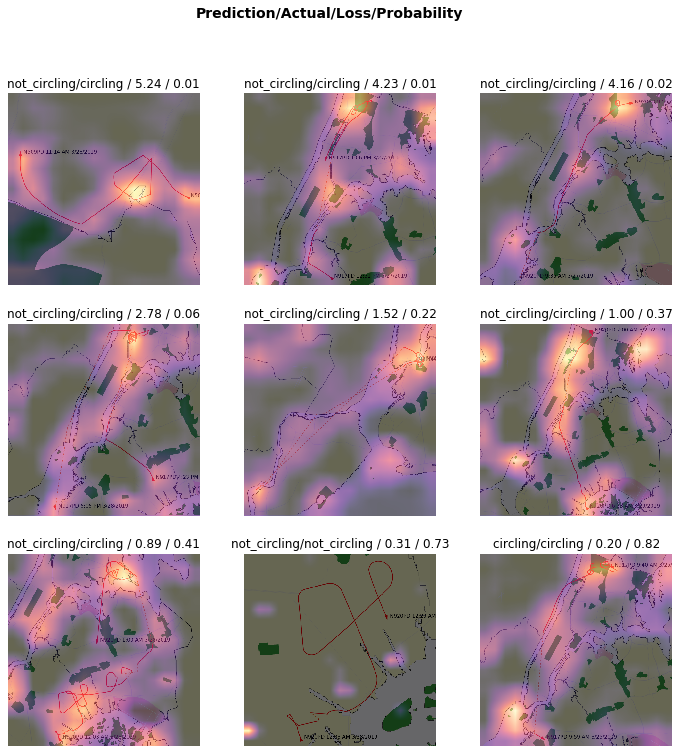

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, heatmap=True)

The "hot" areas of the images are the parts the model is using to make its decision.

When we plot the confusion matrix, we can see how the mistakes are being made. 

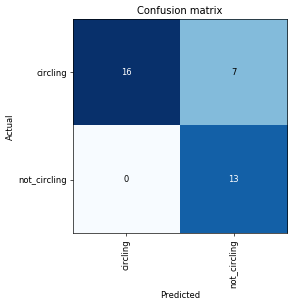

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

Let's try a brand new image.

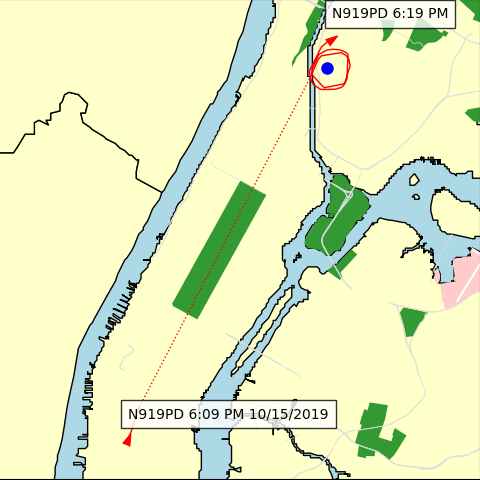

In [0]:
img = open_image('data/not_yet_seen.png')
img

Then we _predict_ what class this image falls into. 

In [0]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category circling